In [15]:
import os
import torch
from scipy import signal
import heartpy.filtering
import numpy as np
import sys
import wfdb
from ecg_qc.ecg_qc import EcgQc
import pandas as pd
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [10]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []
part = 1

In [ ]:
## Loop ecg.bin files
for participant, file in enumerate(data_files):
    counter = 0

    if participant==part:

        logging.critical("Participant: " + str(participant) + "/" + str(len(data_files)))

        data = data['ECG'].values
        ECG_SIGNAL = torch.Tensor(data)  # Final numpy array containing full days record

        # windows of 10 s
        for i in range(0, data.size, fs):
            min_limit = i
            max_limit = i + win * fs

            if (max_limit <= data.size):

                # Save path
                counter = counter + 1
                name_sample = "{}_{:012d}".format(participant, counter)
                names_samples.append(name_sample)

                window_complete = ECG_SIGNAL[min_limit:max_limit]

                # Median Filter
                med = signal.medfilt(window_complete, 3)

                # Bandpass Filter
                filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                        filtertype='bandpass')

                # Signal Quality
                signal_quality_now = []
                win_intra = 1
                for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
                    min_limit = k - win_intra * fs
                    max_limit = k
                    window_complete_intra = filt[min_limit:max_limit]
                    ecg_qc = EcgQc(model_file='rfc_2s.pkl', sampling_frequency=fs, normalized=False)
                    signal_quality_now.append(ecg_qc.get_signal_quality(window_complete_intra))

                signal_quality.append(np.mean(signal_quality_now))

In [ ]:
np.save(f'signal_quality_{part+1}.npy', np.array(signal_quality))

In [11]:
# Load signal_quality from a file named 'signal_quality_2.npy'
signal_quality_2_path = os.path.join(f'signal_quality_{part+1}.npy')
signal_quality = np.load(signal_quality_2_path)
print(signal_quality)

[1.  1.  1.  ... 0.4 0.6 0.6]


In [43]:
is_quality = signal_quality < 0.6
print(is_quality)

[False False False ...  True False False]


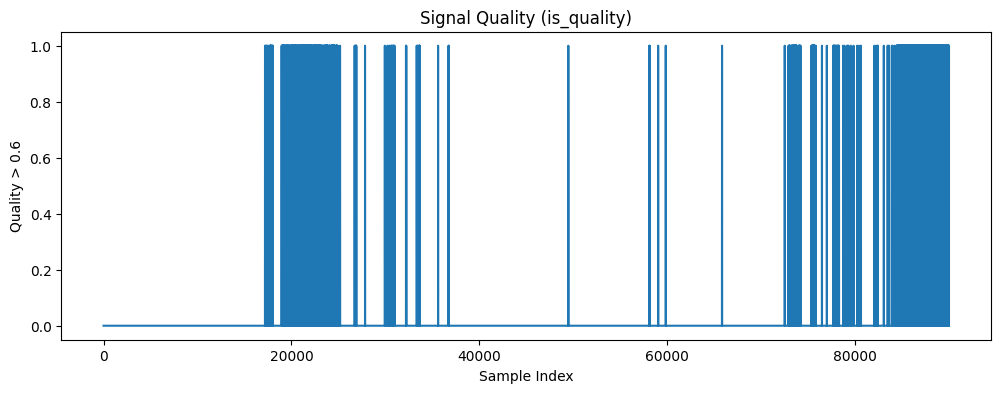

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(is_quality)
plt.title('Signal Quality (is_quality)')
plt.xlabel('Sample Index')
plt.ylabel('Quality > 0.6')
plt.show()

In [46]:
arteffects_intervals = []
min_limit = 0
max_limit = 0

for i,is_arteffect in enumerate(is_quality):

    if is_arteffect==True and (max_limit/fs) <=i:
        min_limit = i*fs
        max_limit = (i+5)*fs
        condition = True
        k = i
        while condition:
            k = k + 1
            if k<=len(is_quality)-1:
                if is_quality[k]==True:
                    max_limit = max_limit + fs
                else:
                    condition = False
            else:
                break
        arteffects_intervals.append((min_limit, max_limit))
            



In [24]:
ECG_SIGNAL = torch.Tensor(wfdb.rdsamp(data_files[part][:-4])[0][:,0])

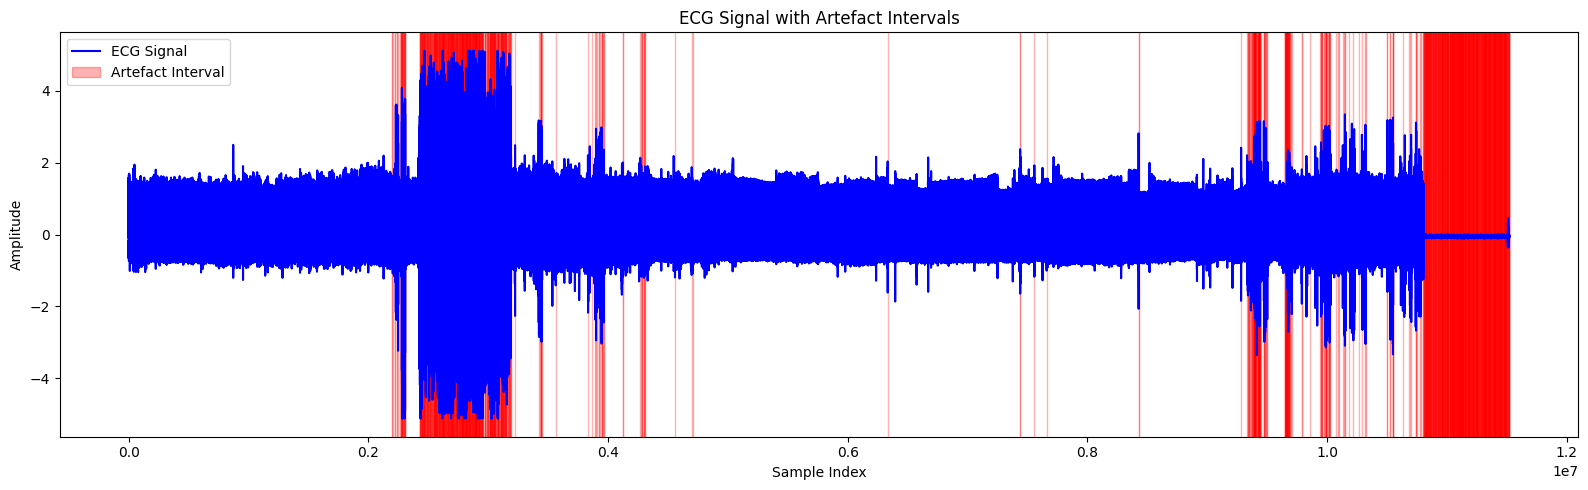

In [47]:
plt.figure(figsize=(16, 5))
plt.plot(ECG_SIGNAL.numpy(), label='ECG Signal', color='blue')

for start, end in arteffects_intervals:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Artefact Interval' if start == arteffects_intervals[0][0] else "")

plt.title('ECG Signal with Artefact Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()